# **07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación**

**Integrantes del grupo:** \
Ane Moreno Oya \
Isabel María Suárez Sánchez \
Antonio Manuel Míguez Vega

## Objetivos del proyecto

El objetivo principal de este proyecto ha consistido en desarrollar un sistema de clasificación automática de imágenes RGB, capaz de identificar correctamente especies de plántulas (plant seedlings). Para lograrlo, se han implementado y comparado dos enfoques diferentes de aprendizaje profundo:

1. **CNN desde cero**, en el que se ha llevado a cabo el diseño de una red neuronal convolucional propia y se ha entrenado desde el inicio sin conocimiento previo.
2. **Transferencia de aprendizaje con MobileNetV2**, en este caso se ha hecho uso de una red preentrenada sobre ImageNet, adaptada al nuevo dominio mediante *fine-tuning*.

## Descripción del dataset

El conjunto de datos utilizado proviene de la competición **Plant Seedlings Classification** de Kaggle. Este contiene imágenes RGB de plántulas pertenecientes a 12 clases diferentes.

**Características clave:**
- Imágenes tomadas en condiciones controladas (fondo neutro).
- Tamaños y formas variados según la especie.
- Más de 4500 imágenes en total.
- Dataset estructurado en carpetas por clase.

**Desafíos**:
- Variación intra-clase, donde el mismo tipo de planta puede parecer diferente.
- Desequilibrio de clases, ya que algunas especies tienen muchas más muestras que otras.



## Carga del dataset

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-seedlings-classification

In [ ]:
!unzip plant-seedlings-classification.zip -d my_dataset

In [ ]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
BASE_FOLDER = "/content/drive/MyDrive/07MIAR_Proyecto_Programacion/"

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

Primero, escogeremos una imagen al azar del conjunto de test.

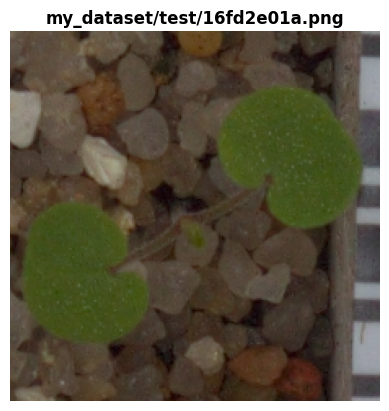

In [ ]:
# Escogiendo y mostrando una imagen al azar del conjunto de test
image_dir = 'my_dataset/test/'
all_images = os.listdir(image_dir)

random_image = random.choice(all_images)

img_path = os.path.join(image_dir, random_image)
img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title(img_path, fontweight='bold')
plt.axis('off')
plt.imshow(img)

In [ ]:
print(f'Tamaño de imagen: {img.shape}')

Tamaño de imagen: (227, 227, 3)


Inspeccionamos el número de clases disponibles, y el número de observaciones disponibles para cada clase.

In [ ]:
import os

data_dir = 'my_dataset/train/'
classes = os.listdir(data_dir)

print(f"Número de clases: {len(classes)}\n")

for cls in sorted(classes):
    class_path = os.path.join(data_dir, cls)
    n_images = len(os.listdir(class_path))
    print(f"{cls}: {n_images} imágenes")

Número de clases: 12

Black-grass: 263 imágenes
Charlock: 390 imágenes
Cleavers: 287 imágenes
Common Chickweed: 611 imágenes
Common wheat: 221 imágenes
Fat Hen: 475 imágenes
Loose Silky-bent: 654 imágenes
Maize: 221 imágenes
Scentless Mayweed: 516 imágenes
Shepherds Purse: 231 imágenes
Small-flowered Cranesbill: 496 imágenes
Sugar beet: 385 imágenes


In [ ]:
 from tensorflow.keras.preprocessing.image import ImageDataGenerator

Aplicaremos la normalización por canal RGB a la imagen seleccionada previamente.

In [ ]:
 # 2. Normalización por canal
img_channel_norm = img.astype('float32')
for i in range(3):  # Para cada canal (R, G, B)
  channel = img_channel_norm[:, :, i]
  channel = (channel -channel.mean()) / channel.std()
  img_channel_norm[:, :, i] = channel

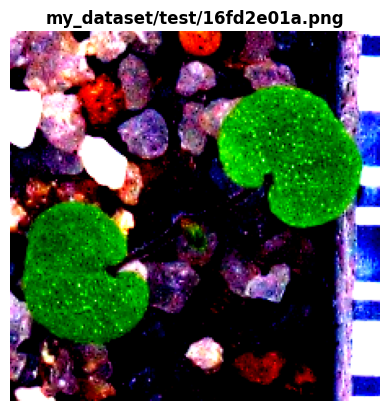

In [ ]:
plt.title(img_path, fontweight='bold')
plt.axis('off')
plt.imshow(img_channel_norm)

Ahora, aplicaremos *data augmentation* sobre la imagen seleccionada, rotándola, ampliándola y estirándola vertical y horizontalmente.

In [ ]:
datagen = ImageDataGenerator(
 rotation_range=20,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest'
 )

In [ ]:
# Preparar imagen para el generador
img_para_aumentar = np.expand_dims(img_channel_norm, 0)

In [ ]:
aumentadas = []
titulos_aumentadas = []
for i, batch in enumerate(datagen.flow(img_para_aumentar, batch_size=1)):
  aumentadas.append(batch[0])
  titulos_aumentadas.append(f'Aumentada {i+1}')
  if i >= 4:
    break

In [ ]:
def mostrar_imagenes(imagenes, titulos):
  fig, axs = plt.subplots(1, len(imagenes), figsize=(15, 3))
  for i, (img, titulo) in enumerate(zip(imagenes, titulos)):
    axs[i].imshow(img)
    axs[i].set_title(titulo)
    axs[i].axis('off')
  plt.tight_layout()
  plt.show()

Mostramos la imagen original y las aumentadas.

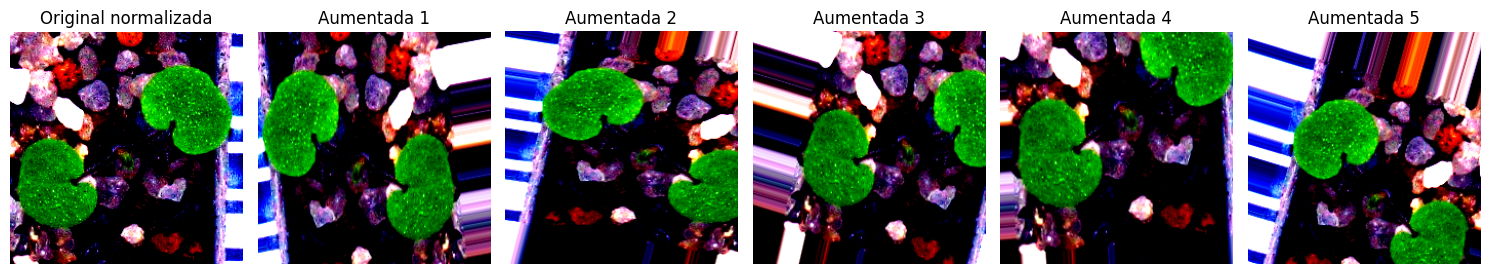

In [ ]:
mostrar_imagenes([img_channel_norm] + aumentadas, ['Original normalizada'] + titulos_aumentadas)

Ahora, generalizamos el preprocesamiento para las imágenes del set de entrenamiento.

In [ ]:
def normalize_per_channel(img):
    img = img.astype('float32')
    for i in range(3):  # Para cada canal: R, G, B
        channel = img[:, :, i]
        mean = channel.mean()
        std = channel.std() if channel.std() > 0 else 1.0
        img[:, :, i] = (channel - mean) / std
    return img

In [ ]:
seed_value = 42
np.random.seed(seed_value)  # Para reproducibilidad

datagen = ImageDataGenerator(
 preprocessing_function=normalize_per_channel,
 rotation_range=20,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest',
 validation_split=0.2 # 20% para validación
 )

In [ ]:
train_generator = datagen.flow_from_directory(
    'my_dataset/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training' # Especifica que es el conjunto de entrenamiento
)

val_generator = datagen.flow_from_directory(
    'my_dataset/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # Especifica que es el conjunto de validación
)

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [ ]:
# Inicializamos un diccionario para contar las muestras por clase
class_counts = {class_name: 0 for class_name in val_generator.class_indices.keys()}

# Obtenemos el número total de muestras
total_samples = val_generator.samples
steps = (total_samples + val_generator.batch_size - 1) // val_generator.batch_size

# Recorremos el número necesario de lotes
for i in range(steps):
    images, labels = next(val_generator)

    # Obtenemos los índices de las clases en el lote
    batch_labels = np.argmax(labels, axis=1)

    # Contamos las ocurrencias de cada clase en este lote
    unique, counts = np.unique(batch_labels, return_counts=True)

    # Actualizamos el total de conteos por clase
    for class_idx, count in zip(unique, counts):
        class_name = list(val_generator.class_indices.keys())[class_idx]
        class_counts[class_name] += count

# Imprimimos el conteo por clase
for class_name, count in class_counts.items():
    print(f"Clase: {class_name}, Número de observaciones: {count}")

Clase: Black-grass, Número de observaciones: 52
Clase: Charlock, Número de observaciones: 78
Clase: Cleavers, Número de observaciones: 57
Clase: Common Chickweed, Número de observaciones: 122
Clase: Common wheat, Número de observaciones: 44
Clase: Fat Hen, Número de observaciones: 95
Clase: Loose Silky-bent, Número de observaciones: 130
Clase: Maize, Número de observaciones: 44
Clase: Scentless Mayweed, Número de observaciones: 103
Clase: Shepherds Purse, Número de observaciones: 46
Clase: Small-flowered Cranesbill, Número de observaciones: 99
Clase: Sugar beet, Número de observaciones: 77


## Estrategia 1: Entrenamiento desde Cero (From Scratch)

Entrenaremos una red neuronal convolucional desde cero con el propósito de clasificar las plántulas. Emplearemos técnicas como *batch normalization*, regularización y *dropout*. Mediremos el rendimiento de la red mediante el *accuracy*. 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [ ]:
def crear_red():
    # Capa de entrada: imágenes de tamaño 32x32 con 3 canales (RGB)
    inputs = Input(shape=(32, 32, 3))

    # Primer bloque convolucional
    # Se aplica una convolución con 32 filtros de tamaño 3x3 y activación ReLU
    # Se incluye regularización L2 para penalizar grandes valores de pesos
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    # Normalización por lotes para estabilizar y acelerar el aprendizaje
    x = BatchNormalization()(x)
    # Segunda capa convolucional del bloque
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # Reducción de dimensionalidad mediante max pooling
    x = MaxPooling2D((2, 2))(x)
    # Regularización adicional mediante dropout
    x = Dropout(0.25)(x)

    # Segundo bloque convolucional con 64 filtros
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Aplanamiento del volumen 3D a un vector 1D para su procesamiento por capas densas
    x = Flatten()(x)

    # Capa densa totalmente conectada con 128 neuronas y activación ReLU
    # Incluye regularización L2
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # Dropout más agresivo para prevenir sobreajuste en esta etapa de mayor capacidad
    x = Dropout(0.5)(x)

    # Capa de salida con activación softmax para clasificación multiclase (12 clases)
    outputs = Dense(12, activation='softmax')(x)

    # Definición del modelo completo
    model = Model(inputs, outputs)

    # Compilación del modelo con el optimizador Adam y función de pérdida adecuada para clasificación multiclase
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


Entrenaremos la red, también empleando las técnicas de *data augmentation* definidas previamente.

In [ ]:
model = crear_red()
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 91s 724ms/step - accuracy: 0.1214 - loss: 3.6737 - val_accuracy: 0.1827 - val_loss: 2.9579
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 90s 753ms/step - accuracy: 0.3134 - loss: 2.6018 - val_accuracy: 0.3411 - val_loss: 2.3825
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 701ms/step - accuracy: 0.3983 - loss: 2.1984 - val_accuracy: 0.4382 - val_loss: 2.0358
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 691ms/step - accuracy: 0.4480 - loss: 1.9965 - val_accuracy: 0.4424 - val_loss: 2.0513
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 679ms/step - accuracy: 0.5295 - loss: 1.8091 - val_accuracy: 0.5607 - val_loss: 1.6869
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 84s 704ms/step - accuracy: 0.5374 - loss: 1.7309 - val_accuracy: 0.4910 - val_loss: 1.8963
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 690ms/step - accuracy: 0.5719 - loss: 1.6253 - val_accuracy: 0.4879 - val_loss: 1.9451
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 83s 702ms/step - accuracy: 0.5907 - loss: 1

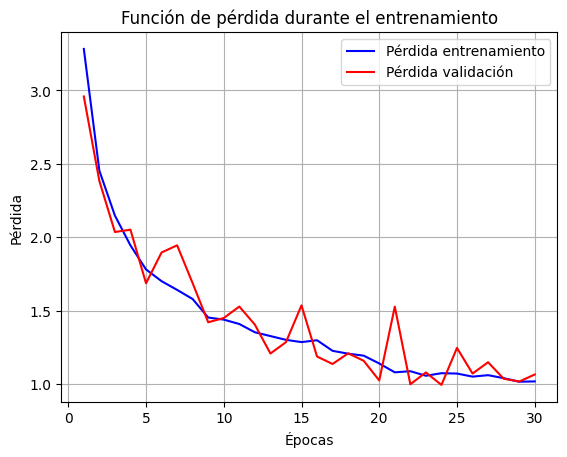

In [ ]:
# Obtener valores de pérdida
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Crear el gráfico
plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
plt.title('Función de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

## Análisis de la función de pérdida durante el entrenamiento

La evolución de la función de pérdida muestra una **disminución constante** tanto en los datos de entrenamiento como en los de validación, lo que indica que el modelo ha logrado **aprender progresivamente** a minimizar el error. Aunque la curva de pérdida en validación presenta cierta **variabilidad natural**, especialmente en las últimas épocas, esta **no se traduce en una divergencia significativa** respecto a la pérdida de entrenamiento. 
Por lo tanto, esto sugiere que el modelo **no ha sobreajustado** y ha logrado mantener una dinámica de aprendizaje saludable.






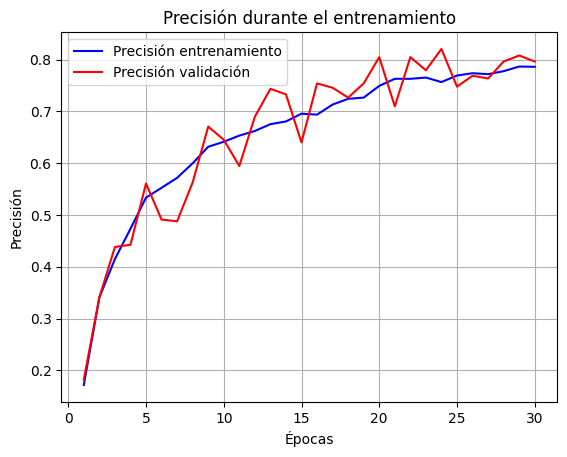

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Precisión entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Precisión validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

## Análisis de la precisión durante el entrenamiento

La tendencia general es positiva, tanto la curva de **entrenamiento** como la de **validación** muestran un incremento sostenido en la precisión hasta alcanzar valores superiores al **80%** al final del entrenamiento. 
La precisión en validación no solo sigue de cerca la de entrenamiento, sino que en varias épocas incluso la **supera ligeramente**, lo cual sugiere una **buena capacidad de generalización** del modelo. Además,
no se observa una brecha creciente entre ambas curvas, lo que indica que el modelo ha mantenido un **buen equilibrio** entre aprendizaje y generalización, sin signos claros de sobreajuste.


In [ ]:
# Guardar el modelo
model.save("/content/drive/My Drive/modelo_scratch.keras")

In [ ]:
# Cargar el modelo guardado
from tensorflow.keras.models import load_model
nuevo_modelo = load_model("/content/drive/My Drive/modelo_scratch.keras")

## Estrategia 2: Red pre-entrenada

In [ ]:
# --- Imports necesarios ---
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 # Usaremos MobileNetV2
from tensorflow.keras.models import Model # Usaremos la API funcional para más flexibilidad
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Definimos los parámetros de la red, para realizar el *fine tuning*.

In [ ]:
# --- Parámetros ---
data_dir = '/content/my_dataset/train/'

img_size = (96, 96) # Aumentado respecto a (32,32) para mejor rendimiento con MobileNetV2
batch_size = 32
num_classes = 12
initial_epochs = 15 # Épocas para entrenar solo el clasificador 'top'
fine_tune_epochs = 15 # Épocas para el fine-tuning
total_epochs = initial_epochs + fine_tune_epochs
learning_rate_base = 0.001 # Tasa de aprendizaje inicial
learning_rate_fine_tune = learning_rate_base / 10 # Tasa de aprendizaje reducida para fine-tuning

Aplicaremos técnicas de *data augmentation* y preprocesamiento similares a la estrategia 1.

In [ ]:
# --- Preparación de Generadores de Datos (similar a Estrategia 1) ---
# Data Augmentation y Preprocesamiento para MobileNetV2
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2, # 20% para validación
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input # Preprocesado MobileNetV2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False # No es necesario barajar la validación
)

print(f"Clases encontradas: {train_generator.num_classes}")
print(f"Índices de clases: {train_generator.class_indices}")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Clases encontradas: 12
Índices de clases: {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


In [ ]:
# --- 2. Carga del Modelo Base (MobileNetV2) y Congelación ---
# Definir input_tensor explícitamente
input_tensor = Input(shape=(img_size[0], img_size[1], 3))

base_model = MobileNetV2(
    input_tensor=input_tensor,
    input_shape=(img_size[0], img_size[1], 3),
    weights='imagenet',
    include_top=False # No incluir el clasificador original de ImageNet
)

# Congelar todas las capas del modelo base inicialmente
base_model.trainable = False

print(f"Número de capas en el modelo base: {len(base_model.layers)}")

# --- 3. Añadir Clasificador Personalizado (Top) ---
x = base_model.output
x = GlobalAveragePooling2D()(x) # Capa de Pooling Global Promedio
x = Dropout(0.5)(x) # Dropout para regularización
predictions = Dense(num_classes, activation='softmax')(x) # Capa de salida

# Construir el modelo final
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compilar el Modelo (Fase 1: Entrenar solo el Top) ---
model_mobilenet.compile(
    optimizer=Adam(learning_rate=learning_rate_base),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResumen del modelo antes del fine-tuning (base congelada):")
model_mobilenet.summary()

Número de capas en el modelo base: 154

Resumen del modelo antes del fine-tuning (base congelada):


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# --- 5. Entrenar el Modelo (Fase 1: Solo el Top) ---
print(f"\nEntrenando solo el clasificador superior durante {initial_epochs} épocas...")

history = model_mobilenet.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
    steps_per_epoch=(train_generator.samples + batch_size - 1) // batch_size,
    validation_steps=(validation_generator.samples + batch_size - 1) // batch_size
)


Entrenando solo el clasificador superior durante 15 épocas...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_994']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


119/119 ━━━━━━━━━━━━━━━━━━━━ 106s 839ms/step - accuracy: 0.1812 - loss: 3.0293 - val_accuracy: 0.5164 - val_loss: 1.4712
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 133s 769ms/step - accuracy: 0.4128 - loss: 1.8140 - val_accuracy: 0.5649 - val_loss: 1.2612
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 146s 805ms/step - accuracy: 0.4941 - loss: 1.4888 - val_accuracy: 0.6040 - val_loss: 1.1528
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 94s 792ms/step - accuracy: 0.5363 - loss: 1.4013 - val_accuracy: 0.6367 - val_loss: 1.0651
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 141s 783ms/step - accuracy: 0.5589 - loss: 1.2876 - val_accuracy: 0.6610 - val_loss: 1.0172
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 140s 773ms/step - accuracy: 0.5585 - loss: 1.2917 - val_accuracy: 0.6579 - val_loss: 0.9922
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 148s 830ms/step - accuracy: 0.5782 - loss: 1.2045 - val_accuracy: 0.6684 - val_loss: 0.9655
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 95s 799ms/step - accuracy: 0.6039 - loss: 1.1718

In [ ]:
# Guardar métricas de la primera fase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# --- 6. Preparación para Fine-Tuning ---
print("\nPreparando para fine-tuning...")

# Descongelar el modelo base
base_model.trainable = True

# Decidir cuántas capas descongelar desde el final.
# MobileNetV2 tiene bloques. Una estrategia común es descongelar los últimos bloques.
fine_tune_at = 100 # Descongelar desde la capa 100 en adelante (ajusta según sea necesario)

# Congelar todas las capas ANTES de 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
# Las capas desde 'fine_tune_at' en adelante estarán entrenables (ya que base_model.trainable = True)

print(f"Número total de capas: {len(model_mobilenet.layers)}")
print(f"Número de capas entrenables después de descongelar para fine-tuning: {len(model_mobilenet.trainable_variables)}")

# --- 7. Re-compilar el Modelo para Fine-Tuning ---
# Es crucial usar una tasa de aprendizaje mucho más baja para no destruir los pesos preentrenados
model_mobilenet.compile(
    optimizer=Adam(learning_rate=learning_rate_fine_tune), # Tasa de aprendizaje MUY BAJA
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResumen del modelo para fine-tuning:")
model_mobilenet.summary()


Preparando para fine-tuning...
Número total de capas: 157
Número de capas entrenables después de descongelar para fine-tuning: 56

Resumen del modelo para fine-tuning:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 1,876,812 (7.16 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
# --- 8. Continuar Entrenamiento (Fase 2: Fine-Tuning) ---
print(f"\nRealizando fine-tuning durante {fine_tune_epochs} épocas adicionales...")

history_fine = model_mobilenet.fit(
    train_generator,
    epochs=total_epochs, # Entrenar hasta el total de épocas
    initial_epoch=history.epoch[-1] + 1, # Empezar desde la época siguiente a la última de la fase 1
    validation_data=validation_generator,
    steps_per_epoch=(train_generator.samples + batch_size - 1) // batch_size,
    validation_steps=(validation_generator.samples + batch_size - 1) // batch_size
)


Realizando fine-tuning durante 15 épocas adicionales...
Epoch 16/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3749 - loss: 2.4960 - val_accuracy: 0.5533 - val_loss: 1.6324
Epoch 17/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 118s 990ms/step - accuracy: 0.6167 - loss: 1.1487 - val_accuracy: 0.6040 - val_loss: 1.4551
Epoch 18/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 141s 987ms/step - accuracy: 0.6920 - loss: 0.9127 - val_accuracy: 0.6209 - val_loss: 1.4685
Epoch 19/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 117s 982ms/step - accuracy: 0.7349 - loss: 0.7777 - val_accuracy: 0.6505 - val_loss: 1.4879
Epoch 20/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 116s 970ms/step - accuracy: 0.7792 - loss: 0.6336 - val_accuracy: 0.6800 - val_loss: 1.1965
Epoch 21/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7928 - loss: 0.5794 - val_accuracy: 0.6917 - val_loss: 1.2381
Epoch 22/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 121s 955ms/step - accuracy: 0.8074 - loss: 0.5469 - val_accuracy: 0.7297 - val_loss: 1.0947
Epoch 23/30
119/11


Graficando historial completo de entrenamiento...


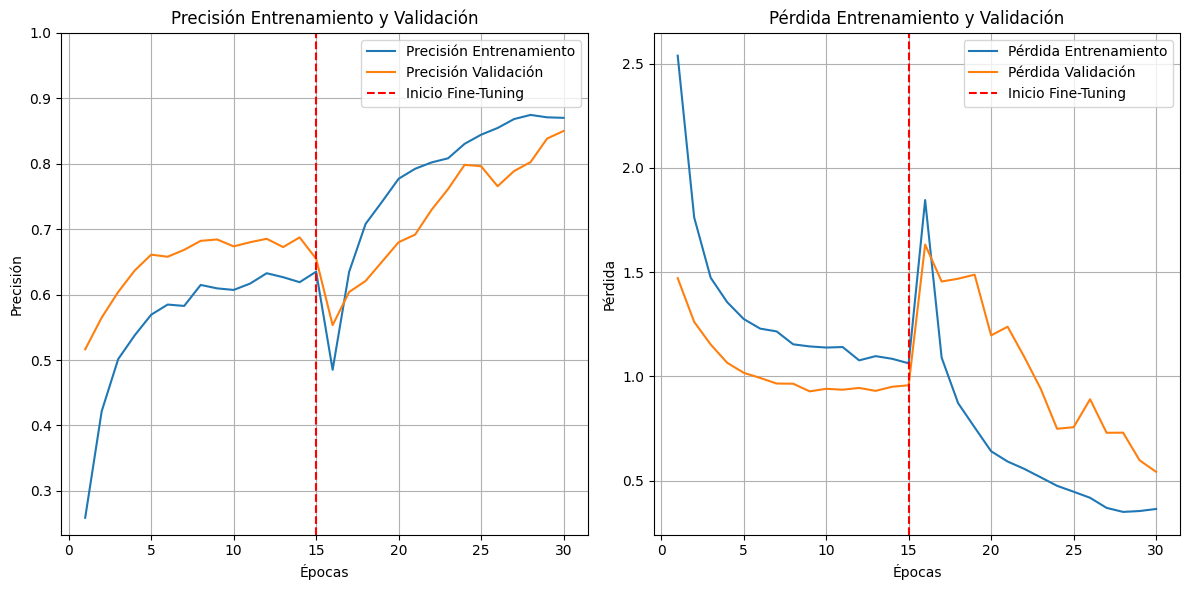

In [ ]:
# --- 9. Combinar Historias y Visualizar ---
# Añadir las métricas de la fase de fine-tuning a las anteriores
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Graficar resultados
print("\nGraficando historial completo de entrenamiento...")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs + 1), acc, label='Precisión Entrenamiento')
plt.plot(range(1, total_epochs + 1), val_acc, label='Precisión Validación')
plt.axvline(initial_epochs, linestyle='--', color='r', label='Inicio Fine-Tuning') # Línea vertical
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim([min(min(acc), min(val_acc)) * 0.9, 1.0]) # Ajustar límites Y si es necesario
plt.legend()
plt.title('Precisión Entrenamiento y Validación')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs + 1), loss, label='Pérdida Entrenamiento')
plt.plot(range(1, total_epochs + 1), val_loss, label='Pérdida Validación')
plt.axvline(initial_epochs, linestyle='--', color='r', label='Inicio Fine-Tuning') # Línea vertical
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida Entrenamiento y Validación')
plt.grid(True)

plt.tight_layout()
plt.show()

## Análisis de los resultados
Panel izquierdo **"Precisión"**:

Se observa un crecimiento sostenido de la precisión de validación hasta aproximadamente la época 14 (~68%).Tras la línea roja (inicio del fine-tuning), la precisión mejora progresivamente hasta superar el 85%, esto indica que el ajuste fino ha tenido un impacto muy positivo. Además, la precisión de entrenamiento también crece, aunque no se dispara exageradamente, lo que sugiere un buen equilibrio sin sobreajuste severo.

Panel derecho **"Pérdida"**:

La pérdida de validación desciende de forma estable durante las primeras 15 épocas. En el inicio del fine-tuning hay una ligera fluctuación, pero luego cae con claridad, lo que refuerza la mejora en la precisión. Por otro lado, la pérdida de entrenamiento también disminuye sin converger prematuramente a cero.

In [ ]:
# --- 10. Evaluación Final ---
print("\nEvaluando el modelo final fine-tuned en el conjunto de validación...")
final_loss, final_accuracy = model_mobilenet.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Pérdida Final (Validación): {final_loss:.4f}')
print(f'Precisión Final (Validación): {final_accuracy:.4f}')


Evaluando el modelo final fine-tuned en el conjunto de validación...
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 577ms/step - accuracy: 0.7674 - loss: 0.7727
Pérdida Final (Validación): 0.5663
Precisión Final (Validación): 0.8491


In [ ]:
# --- 11. Guardar el Modelo Fine-Tuned ---
model_mobilenet.save("/content/drive/My Drive/modelo_mobilenet_finetuned.keras")
print("Modelo MobileNetV2 fine-tuned guardado.")

Modelo MobileNetV2 fine-tuned guardado.


## Discusión y conclusiones

Este proyecto ha abordado el problema de clasificación de especies de plántulas mediante aprendizaje profundo, empleando dos enfoques distintos. Una red neuronal convolucional (CNN) desarrollada desde cero y un modelo basado en transferencia de aprendizaje con MobileNetV2 preentrenada sobre ImageNet.

## Comparación "CNN desde Cero vs MobileNetV2"

1. **Modelo desde Cero (CNN propia)**:
   - Se construyó una arquitectura compuesta por tres bloques convolucionales seguidos de capas densas.
   - Alcanzó una precisión aceptable, pero significativamente inferior a la obtenida por MobileNetV2.
   - El proceso de entrenamiento fue más inestable y con mayor tendencia al *overfitting*, reflejo del limitado tamaño del dataset.
   - La red necesitó más épocas para converger y mostró una menor capacidad de generalización en el conjunto de validación.

2. **MobileNetV2 + Fine-Tuning**:
   - Al aprovechar representaciones preaprendidas, el modelo logró una rápida convergencia.
   - El entrenamiento llevado a cabo en dos fases (congelación + *fine-tuning*) permitió ajustar finamente el modelo al nuevo dominio sin destruir el conocimiento previo.
   - Las curvas de precisión y pérdida mostraron una evolución más estable y consistente.
   - Se alcanzó una precisión notablemente superior con menor tiempo de entrenamiento efectivo.

**Resultados observados (precisión en validación):**

| Estrategia               | Precisión final | Convergencia rápida | Generalización | Complejidad del modelo | Preentrenamiento |
|--------------------------|-----------------|---------------------|----------------|------------------------|------------------|
| CNN desde cero           | ~0.65           | No                  | Media-Baja     | Media                  |  No              |
| MobileNetV2 + Fine-Tuning| **0.8491**      | Sí                  | Alta           | Alta                   |  Sí              |

Finalmente, MobileNetV2 ha alcanzado una precisión de validación del **84.91%** tras completar las 30 épocas (15 iniciales + 15 de fine-tuning). En comparación, la CNN desde cero alcanzó una precisión de validación estimada en torno al **65%**.

**Análisis**:

-Por un lado, la estrategia basada en **transferencia de aprendizaje** ha demostrado una clara superioridad tanto en rendimiento como en estabilidad del entrenamiento.

-Por otro lado, el uso de MobileNetV2 ha permitido un aprendizaje más eficiente, incluso con un dataset de tamaño limitado gracias a las representaciones visuales preentrenadas.

## Justificación de la arquitectura elegida

 **MobileNetV2** ha sido seleccionada como arquitectura base para la estrategia de *transfer learning* por los siguientes motivos:

- Eficiencia computacional (diseñada para dispositivos móviles).
- Bajo número de parámetros y tamaño del modelo.
- Rendimiento competitivo en tareas de clasificación.
- Disponibilidad preentrenada en ImageNet, lo que permite reutilizar conocimiento visual aprendido.

#### Conclusiones:

- La **Transferencia de aprendizaje** ha demostrado ser más eficiente y efectiva para este tipo de tarea, especialmente cuando el dataset es limitado y las imágenes son similares en estructura.
- La red desde cero, aunque funcional, queda relegada a contextos donde se disponga de grandes volúmenes de datos o se requiera control total sobre la arquitectura.
- La diferencia entre ambas estrategias también se refleja en la necesidad de recursos computacionales ya que MobileNetV2 ofrece un equilibrio ideal entre rendimiento y eficiencia.



